<a href="https://colab.research.google.com/github/chuducthang77/Deep-Learning-project/blob/main/Generative_adversial_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Generate the dataset of fashion-MNIST using GAN

In [ ]:
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

#Get the fashion-Mnist dataset
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [ ]:
# Preprocessing the data 
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
# Noise dimension
z_dim = 100

In [ ]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Generator model
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Discriminator model
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# Plot the loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the sample from Generator model
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
#Save the loss and accuracy of Generator and Discriminator model
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Sample the real image and randomize the noise
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate fake image from noise and create label
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9 #Real image labelling

            # Train discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim)) 
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False #Do not update the weight of discriminator
            g_loss = gan.train_on_batch(noise, y2)

        # Save the loss value
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Plot the result
        if e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 20
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


--------------- Epoch 1 ---------------
--------------- Epoch 5 ---------------


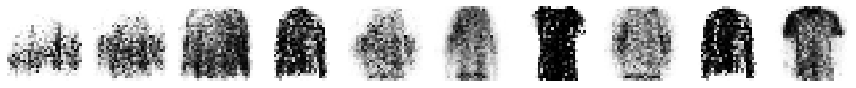

--------------- Epoch 10 ---------------


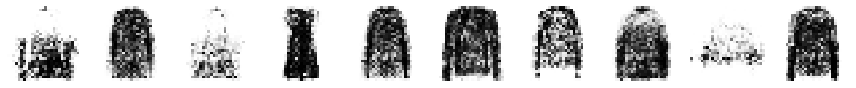

--------------- Epoch 15 ---------------


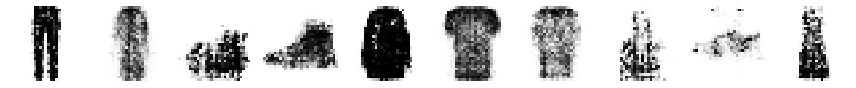

--------------- Epoch 20 ---------------


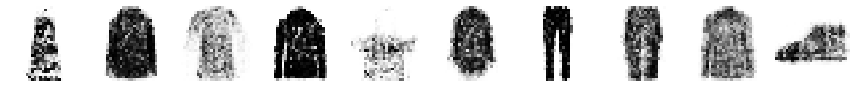

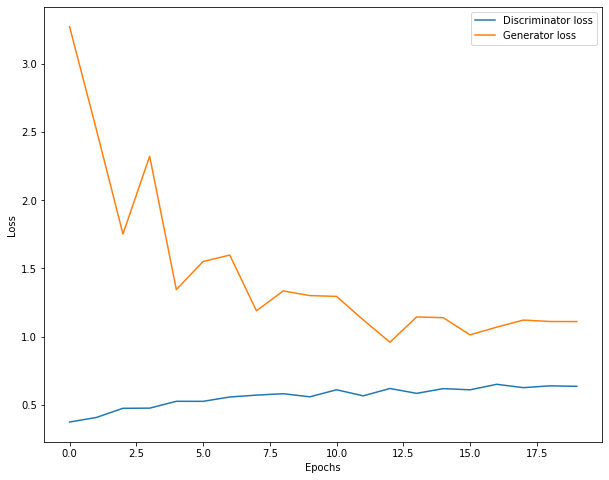

In [ ]:
train(epochs=20, plt_frq=5, BATCH_SIZE=128)

# 2. Generate the dataset of fashion-MNIST using conditional GAN

In [ ]:
from keras.layers import Embedding, Reshape, Concatenate, concatenate, Conv2DTranspose, Conv2D

#Generator Model
y = Input(shape=(1,))
sub_y = Embedding(10, 50)(y)
sub_y = Dense(49)(sub_y)
sub_y = Reshape((7,7,1))(sub_y)

z = Input(shape=(z_dim,))
sub_z = Dense(128*7*7)(z)
sub_z = LeakyReLU(alpha=0.2)(sub_z)
sub_z = Reshape((7,7,128))(sub_z)

merge = Concatenate()([sub_y, sub_z])
merge = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(merge)
merge = LeakyReLU(alpha=0.2)(merge)

merge = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(merge)
merge = LeakyReLU(alpha=0.2)(merge)
merge = Conv2D(1, (7,7), activation='tanh', padding='same')(merge)

generator = Model([z, y], merge)


In [ ]:
#Discriminator Model 
y = Input(shape=(1,))
sub_dis_y = Embedding(10, 50)(y)
sub_dis_y = Dense(28*28)(sub_dis_y)
sub_dis_y = LeakyReLU(alpha=0.2)(sub_dis_y)
sub_dis_y = Reshape((28,28,1))(sub_dis_y)

sub_image = Input(shape=(28,28,1))
merge_dis = Concatenate()([sub_image, sub_dis_y])
merge_dis = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge_dis)
merge_dis = LeakyReLU(alpha=0.2)(merge_dis)
merge_dis = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge_dis)
merge_dis = LeakyReLU(alpha=0.2)(merge_dis)
merge_dis = Flatten()(merge_dis)
merge_dis = Dropout(0.4)(merge_dis)
out_layer = Dense(1, activation='sigmoid')(merge_dis)

discriminator = Model([sub_image, y], out_layer)
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [ ]:
#Conditional Gan Model 
gen_noise, gen_label = generator.input
gen_output = generator.output
gan_output = discriminator([gen_output, gen_label])
cGan = Model([gen_noise, gen_label], gan_output)
cGan.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
#Lưu giá trị loss và accuracy của Discriminator và Generator
losses = {"D1":[], "D2": [], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Randomize the real image from the dataset and train the discriminator
            idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
            x_real = X_train[idx]
            x_real = np.expand_dims(x_real, axis=-1)
            label_real = Y_train[idx]
            y_real = np.ones((BATCH_SIZE,1))
            d_loss_1 = discriminator.train_on_batch([x_real, label_real], y_real)
            
            # Create the fake image and train the discriminator 
            z = np.random.randn(100*BATCH_SIZE).reshape(BATCH_SIZE,100)
            label_fake = np.random.randint(0, 10, BATCH_SIZE)
            x_fake = generator.predict([z, label_fake])
            y_fake = np.zeros((BATCH_SIZE,1))
            d_loss_2 = discriminator.train_on_batch([x_fake, label_fake], y_fake)

            #Train the conditional Gan model
            z_gan = np.random.rand(100*BATCH_SIZE).reshape(BATCH_SIZE, 100)
            label_gan = np.random.randint(0, 10, BATCH_SIZE)
            y_gan = np.ones((BATCH_SIZE, 1))
            g_loss = cGan.train_on_batch([z_gan, label_gan], y_gan)

        # Save the loss values
        losses["D1"].append(d_loss_1)
        losses["D2"].append(d_loss_2)
        losses["G"].append(g_loss)

        # Plot the result
        if e%plt_frq == 0:
            plot_generated()
    
    plot_loss_cGan(losses)

In [17]:
# Plot the conditional GAN loss
def plot_loss_cGan(losses):
    d_loss_1 = [v[0] for v in losses["D1"]]
    d_loss_2 = [v[0] for v in losses["D2"]]
    g_loss = losses['G']
    plt.figure(figsize=(10,8))
    plt.plot(d_loss_1, label="Discriminator 1 loss")
    plt.plot(d_loss_2, label="Discriminator 2 loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epochs: 20
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


--------------- Epoch 1 ---------------
--------------- Epoch 5 ---------------


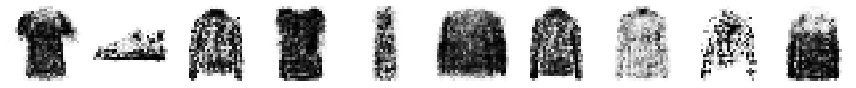

--------------- Epoch 10 ---------------


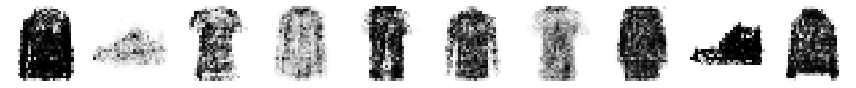

--------------- Epoch 15 ---------------


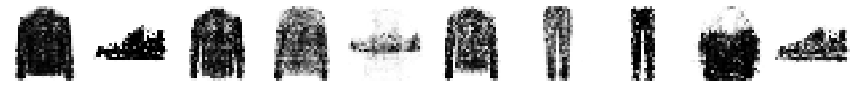

--------------- Epoch 20 ---------------


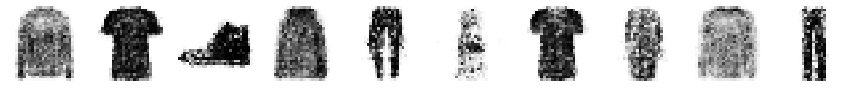

NameError: ignored

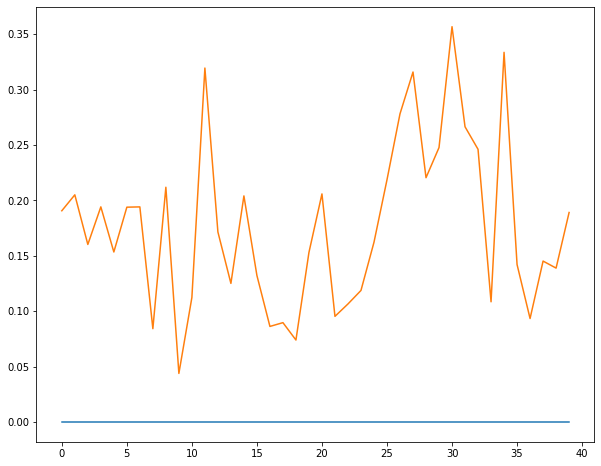

In [16]:
train(epochs=20, plt_frq=5, BATCH_SIZE=128)